In [48]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [49]:
import os, sys

# Add to path the parent directory of this notebook dir

sys.path.append(os.path.dirname(os.getcwd()))
from view import plot_gamblers_value_function, plot_gamblers_policy
from policy_iteration import policy_evaluation_v, find_optimal_policy_q
from value_iteration import value_iteration_q, value_iteration_v_stochastic

In [50]:
import gymnasium as gym
import numpy as np
from typing import Tuple


class GamblersProblemEnv(gym.Env):
    """
    Gambler's Problem environment.
    """

    def __init__(self, goal_amount: int = 100, win_probability: float = 0.4):
        """
        Initialize the environment.

        Args:
            goal_amount (int): The goal capital amount to be achieved.
            win_probability (float): Probability of winning a bet.
        """
        self.goal_amount = goal_amount
        self.win_probability = win_probability

        # Action space: bet an amount from 0 to the current capital
        # Observation space: current capital amount
        self.action_space = gym.spaces.Discrete(goal_amount + 1)
        self.observation_space = gym.spaces.Discrete(goal_amount + 1)

        self.state = None
        self.reset()

    def step(self, action: int) -> Tuple[int, float, bool, dict]:
        """
        Execute one time step within the environment.

        Args:
            action (int): Amount of capital to bet.

        Returns:
            Tuple containing the new state, reward, done flag, and additional info.
        """
        assert self.action_space.contains(action), "Invalid action"

        done = False
        reward = 0

        # Win case
        if np.random.rand() < self.win_probability:
            self.state += action
            if self.state >= self.goal_amount:
                self.state = self.goal_amount
                reward = 1
                done = True
        else:
            # Lose case
            self.state -= action
            if self.state <= 0:
                self.state = 0
                done = True

        truncated = False
        return self.state, reward, done, truncated, {}

    def reset(self) -> int:
        """
        Reset the environment to an initial state.

        Returns:
            The initial state.
        """
        self.state = 1  # Start with capital of $1
        return self.state

    def render(self, mode="human"):
        """
        Render the environment.
        """
        if mode == "human":
            print(f"Current Capital: ${self.state}")
        elif mode == "ansi":
            return f"Current Capital: ${self.state}"
        else:
            raise NotImplementedError("Render mode not supported: " + mode)
        
    def build_mdp(self):
        """
        Build the MDP representation for the Gambler's Problem.
        """
        t_r_dict = {}

        for state in range(1, self.goal_amount):
            for action in range(1, min(state, self.goal_amount - state) + 1):
                win_state = min(state + action, self.goal_amount)
                lose_state = max(state - action, 0)

                # Winning and losing probabilities and rewards
                win_reward = 1 if win_state == self.goal_amount else 0
                win_prob = self.win_probability
                lose_reward = 0
                lose_prob = 1 - self.win_probability

                # Expected reward for the action
                expected_reward = win_prob * win_reward + lose_prob * lose_reward

                t_r_dict[(state, action)] = (win_state, lose_state, expected_reward)

        return t_r_dict


In [51]:
# Create an instance of the environment
env = GamblersProblemEnv(goal_amount=100, win_probability=0.40)

# Generate the MDP representation
t_r_dict = env.build_mdp()
t_r_dict

{(1, 1): (2, 0, 0.0),
 (2, 1): (3, 1, 0.0),
 (2, 2): (4, 0, 0.0),
 (3, 1): (4, 2, 0.0),
 (3, 2): (5, 1, 0.0),
 (3, 3): (6, 0, 0.0),
 (4, 1): (5, 3, 0.0),
 (4, 2): (6, 2, 0.0),
 (4, 3): (7, 1, 0.0),
 (4, 4): (8, 0, 0.0),
 (5, 1): (6, 4, 0.0),
 (5, 2): (7, 3, 0.0),
 (5, 3): (8, 2, 0.0),
 (5, 4): (9, 1, 0.0),
 (5, 5): (10, 0, 0.0),
 (6, 1): (7, 5, 0.0),
 (6, 2): (8, 4, 0.0),
 (6, 3): (9, 3, 0.0),
 (6, 4): (10, 2, 0.0),
 (6, 5): (11, 1, 0.0),
 (6, 6): (12, 0, 0.0),
 (7, 1): (8, 6, 0.0),
 (7, 2): (9, 5, 0.0),
 (7, 3): (10, 4, 0.0),
 (7, 4): (11, 3, 0.0),
 (7, 5): (12, 2, 0.0),
 (7, 6): (13, 1, 0.0),
 (7, 7): (14, 0, 0.0),
 (8, 1): (9, 7, 0.0),
 (8, 2): (10, 6, 0.0),
 (8, 3): (11, 5, 0.0),
 (8, 4): (12, 4, 0.0),
 (8, 5): (13, 3, 0.0),
 (8, 6): (14, 2, 0.0),
 (8, 7): (15, 1, 0.0),
 (8, 8): (16, 0, 0.0),
 (9, 1): (10, 8, 0.0),
 (9, 2): (11, 7, 0.0),
 (9, 3): (12, 6, 0.0),
 (9, 4): (13, 5, 0.0),
 (9, 5): (14, 4, 0.0),
 (9, 6): (15, 3, 0.0),
 (9, 7): (16, 2, 0.0),
 (9, 8): (17, 1, 0.0),
 (9, 9):

In [52]:
# Parameters for policy iteration
gamma = 1
theta = 1e-50

states = list(set([s for s, _ in t_r_dict.keys()]))
actions = list(set([a for _, a in t_r_dict.keys()]))

# Find the optimal policy using Q-value iteration
optimal_policy, optimal_value_function_v = value_iteration_v_stochastic(t_r_dict, states, actions, gamma=gamma, theta=theta)

print("Optimal Policy:", optimal_policy)
print("Value Function:", optimal_value_function_v)

plot_gamblers_policy(optimal_policy, max_capital=env.goal_amount)

TypeError: argmax() got an unexpected keyword argument 'default'

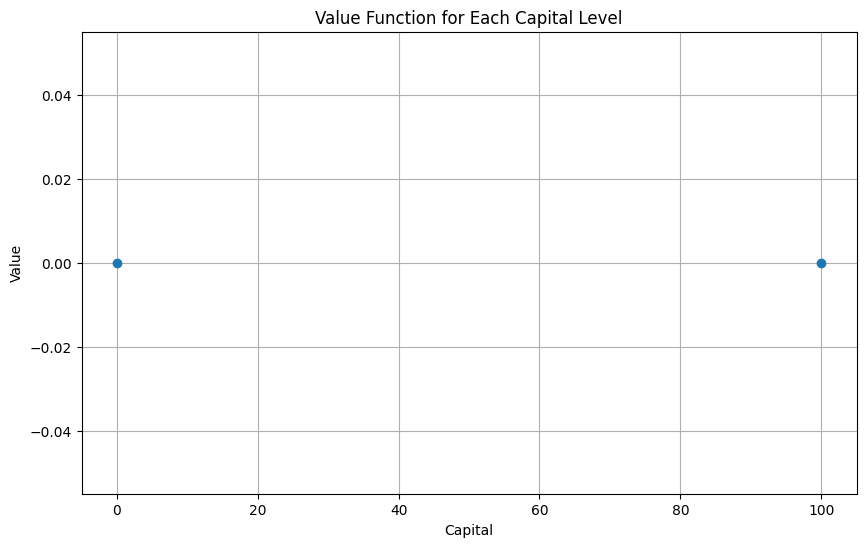

In [ ]:
plot_gamblers_value_function(optimal_value_function_v, max_capital=env.goal_amount)